# Image Preperation

To prepare our dataset for use we will need to do some cleaning and normalizing of the pictures. 
First, we will use the bounding box information we gathered earlier so that our photos will only
have dogs in them. Then we will resize the images so that they are uniform in addition to 
normalizing the colors. 

After we have created our high quality dog images we will do some image augmentation to help 
under represented breeds (n < 200) and breed categories (wild dogs and Foundation Stock Service).
We will do this using 


In [1]:
import pandas as pd
import os 
import xml.etree.ElementTree as ET
from PIL import Image, ImageOps
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input
import tensorflow as tf
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from kerastuner import HyperParameters
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping

df = pd.read_csv('resources/csv/dog_annotations_with_groups.csv')
df.head()

C:\Users\kbuma\AppData\Local\Temp\ipykernel_31852\1011255427.py:16: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperParameters


filename breed_name               folder  xmin  ymin  xmax  \
0  n02085620_10074.jpg  chihuahua  n02085620-Chihuahua    25    10   276   
1  n02085620_10131.jpg  chihuahua  n02085620-Chihuahua    49     9   393   
2  n02085620_10621.jpg  chihuahua  n02085620-Chihuahua   142    43   335   
3   n02085620_1073.jpg  chihuahua  n02085620-Chihuahua     0    27   312   
4  n02085620_10976.jpg  chihuahua  n02085620-Chihuahua    90   104   242   

   ymax         pose  truncated  difficult group_x group_y group  
0   498  Unspecified          0          0     Toy     Toy   Toy  
1   493  Unspecified          0          0     Toy     Toy   Toy  
2   250  Unspecified          0          0     Toy     Toy   Toy  
3   498  Unspecified          0          0     Toy     Toy   Toy  
4   452  Unspecified          0          0     Toy     Toy   Toy

In [ ]:
# error_log = []
# cropped_folder = 'resources/stanford-dogs-dataset/cropped-images'
# image_folder = 'resources/stanford-dogs-dataset/images'
# breed_issues = {}

# for _, row in df.iterrows():
#     breed_name = row["breed_name"]
#     folder_name = row["folder"].strip()  # Strip newlines & spaces
#     filename = row["filename"].strip()  # Ensure filename is not empty

#     # Check if filename is empty or incorrect
#     if not filename or filename == "%s.jpg":
#         # print(f"⚠️ Invalid filename for {breed_name} in {folder_name}")
#         error_log.append(f"Invalid filename for {breed_name} in {folder_name}")
#         continue  # Skip this entry

#     img_path = os.path.join(image_folder, folder_name, filename)

#     if not os.path.exists(img_path):
#         # print(f"⚠️ Missing file: {img_path}")
#         error_log.append(img_path)
#         continue  # Skip missing images

#     try: # Run of the mill image cropping routine
#         # Open image
#         img = Image.open(img_path)

#         # Crop
#         xmin, ymin, xmax, ymax = row["xmin"], row["ymin"], row["xmax"], row["ymax"]
#         cropped_img = img.crop((xmin, ymin, xmax, ymax))

#         # Ensure breed folder exists
#         breed_cropped_path = os.path.join(cropped_folder, breed_name)
#         os.makedirs(breed_cropped_path, exist_ok=True)

#         # Save cropped image
#         save_path = os.path.join(breed_cropped_path, filename)
#         cropped_img.save(save_path)

#     except Exception as e:
#         error_log.append(f"{img_path} - {e}")

# # Save error log
# with open("missing_images_log.txt", "w") as f:
#     for entry in error_log:
#         f.write(f"{entry}\n")

# print(f"✅ Cropping complete! {len(error_log)} issues logged.")

✅ Cropping complete! 1 issues logged.


In [33]:
import os
from PIL import Image

# Expand crop box function with padding
def expand_bbox(xmin, ymin, xmax, ymax, img_width, img_height, padding=0.1):
    """Expand the bounding box by a certain padding."""
    x_pad = int((xmax - xmin) * padding)
    y_pad = int((ymax - ymin) * padding)
    
    # Ensure the crop box stays within image bounds
    xmin = max(0, xmin - x_pad)
    ymin = max(0, ymin - y_pad)
    xmax = min(img_width, xmax + x_pad)
    ymax = min(img_height, ymax + y_pad)
    
    return xmin, ymin, xmax, ymax

# Main cropping loop
error_log = []
cropped_folder = 'resources/stanford-dogs-dataset/cropped-images'
image_folder = 'resources/stanford-dogs-dataset/images'
breed_issues = {}

for _, row in df.iterrows():
    breed_name = row["breed_name"]
    folder_name = row["folder"].strip()  # Strip newlines & spaces
    filename = row["filename"].strip()  # Ensure filename is not empty

    # Check if filename is empty or incorrect
    if not filename or filename == "%s.jpg":
        # print(f"⚠️ Invalid filename for {breed_name} in {folder_name}")
        error_log.append(f"Invalid filename for {breed_name} in {folder_name}")
        continue  # Skip this entry

    img_path = os.path.join(image_folder, folder_name, filename)

    if not os.path.exists(img_path):
        # print(f"⚠️ Missing file: {img_path}")
        error_log.append(img_path)
        continue  # Skip missing images

    try:
        # Open image
        img = Image.open(img_path)
        img_width, img_height = img.size

        # Expand crop box with padding (e.g., 10%)
        xmin, ymin, xmax, ymax = expand_bbox(row["xmin"], row["ymin"], row["xmax"], row["ymax"], img_width, img_height)

        # Crop the image based on updated coordinates
        cropped_img = img.crop((xmin, ymin, xmax, ymax))

        # Ensure breed folder exists
        breed_cropped_path = os.path.join(cropped_folder, breed_name)
        os.makedirs(breed_cropped_path, exist_ok=True)

        # Save cropped image
        save_path = os.path.join(breed_cropped_path, filename)
        cropped_img.save(save_path)

    except Exception as e:
        error_log.append(f"{img_path} - {e}")

# Save error log
with open("missing_images_log.txt", "w") as f:
    for entry in error_log:
        f.write(f"{entry}\n")

print(f"✅ Cropping complete! {len(error_log)} issues logged.")


✅ Cropping complete! 1 issues logged.


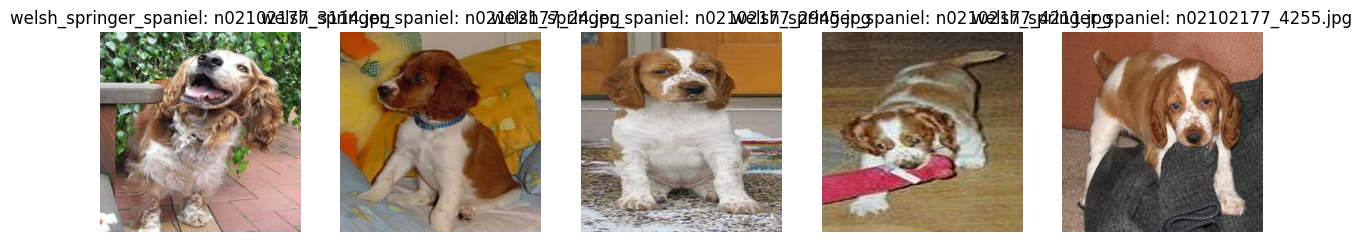

In [36]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Function to display a batch of images
def display_images_from_folder(folder_path, num_images=5, img_size=(256, 256)):
    """Display a batch of images from a given folder."""
    # Get all breed names (subfolder names)
    breed_folders = os.listdir(folder_path)
    
    # Randomly select a breed folder
    breed_folder = random.choice(breed_folders)
    
    # Get a list of all image files in the breed folder
    breed_folder_path = os.path.join(folder_path, breed_folder)
    image_files = os.listdir(breed_folder_path)
    
    # Randomly select images to display
    selected_images = random.sample(image_files, num_images)
    
    # Plot the images
    plt.figure(figsize=(15, 15))
    
    for i, image_file in enumerate(selected_images):
        img_path = os.path.join(breed_folder_path, image_file)
        img = Image.open(img_path)
        img = img.resize(img_size)  # Resize to ensure consistent display size
        
        plt.subplot(1, num_images, i+1)
        plt.imshow(np.array(img))
        plt.axis('off')  # Turn off axis
        plt.title(f"{breed_folder}: {image_file}")
    
    plt.show()

# Path to the cropped images folder
cropped_folder = 'resources/stanford-dogs-dataset/cropped-images'

# Display 5 random images from the cropped folder
display_images_from_folder(cropped_folder, num_images=5, img_size=(256, 256))


In [3]:
expected_breeds = set(df["breed_name"].unique())
actual_breeds = set(os.listdir(cropped_folder))

# Check which breeds are missing from the folders
missing_folders = expected_breeds - actual_breeds
extra_folders = actual_breeds - expected_breeds

print("📌 Breeds in dataset but missing from image folders:", missing_folders)
print("📌 Extra breed folders that don't match dataset:", extra_folders)

📌 Breeds in dataset but missing from image folders: set()
📌 Extra breed folders that don't match dataset: set()


In [4]:
total_imgs = 0
for breed in os.listdir(cropped_folder):
    breed_path = os.path.join(cropped_folder, breed)
    num_images = len(os.listdir(breed_path))
    total_imgs += num_images

print(f"There are {total_imgs} cropped images")
print(f"There are {len(df['breed_name']) - total_imgs} missing images.")


There are 20579 cropped images
There are 1547 missing images.


Updated Preprocessing with pre-trained models

In [22]:
# Set variables
IMG_SIZE = (256, 256)  # Image size
INPUT_SHAPE = (256, 256, 3)  # Image dimensions (RGB)
NUM_CLASSES = 120  # Number of dog breeds in your dataset
BATCH_SIZE = 32  # Number of images the model sees before backpropagating 

def resize_with_padding(image, target_size=IMG_SIZE):
    """Resize an image while keeping aspect ratio and adding padding."""
    image = np.array(image)  # Ensure it's a NumPy array
    
    # Convert image back to uint8 if it's in float32
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)  # Normalize to [0, 255] and convert to uint8

    img = Image.fromarray(image)  # Convert to PIL Image
    img = ImageOps.fit(img, target_size, method=Image.Resampling.LANCZOS, centering=(0.5, 0.5)) 
    return np.array(img)  # Convert back to NumPy array


def preprocess_image(image):
    """Resize with padding and normalize for MobileNet."""
    image = resize_with_padding(image)  # Resize and pad
    image = preprocess_input(image)  # MobileNet normalization (-1 to 1 range)
    return image




In [19]:
# Define ImageDataGenerator with the correct preprocessing
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,  # Now using MobileNet's expected input format
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% validation split
)

# Training and validation generators
train_generator = datagen.flow_from_directory(
    cropped_folder,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    cropped_folder,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)




Found 16507 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [38]:
# Get the list of breed names from your CSV file
expected_breeds = set(df["breed_name"].unique())

# Get the actual breed folders in your cropped folder
actual_breeds = set(os.listdir(cropped_folder))

# Check for missing and extra breeds
missing_breeds = expected_breeds - actual_breeds
extra_breeds = actual_breeds - expected_breeds

print("📌 Breeds in dataset but missing from image folders:", missing_breeds)
print("📌 Extra breed folders that don't match dataset:", extra_breeds)

# Optionally, print the breeds that match
matching_breeds = expected_breeds & actual_breeds
print("📌 Matching breeds:", matching_breeds)


📌 Breeds in dataset but missing from image folders: set()
📌 Extra breed folders that don't match dataset: set()
📌 Matching breeds: {'otterhound', 'border_collie', 'gordon_setter', 'flat-coated_retriever', 'norwegian_elkhound', 'norfolk_terrier', 'walker_hound', 'toy_terrier', 'komondor', 'doberman', 'japanese_spaniel', 'kuvasz', 'dingo', 'dandie_dinmont', 'greater_swiss_mountain_dog', 'bull_mastiff', 'basenji', 'mexican_hairless', 'samoyed', 'cocker_spaniel', 'dhole', 'kelpie', 'schipperke', 'saluki', 'miniature_schnauzer', 'bloodhound', 'newfoundland', 'american_staffordshire_terrier', 'irish_water_spaniel', 'boston_bull', 'wire-haired_fox_terrier', 'saint_bernard', 'great_dane', 'welsh_springer_spaniel', 'standard_schnauzer', 'sealyham_terrier', 'rottweiler', 'pembroke', 'weimaraner', 'pomeranian', 'west_highland_white_terrier', 'cardigan', 'keeshond', 'bluetick', 'papillon', 'groenendael', 'english_setter', 'standard_poodle', 'collie', 'rhodesian_ridgeback', 'malamute', 'old_english

In [39]:
# Check the class indices (label mappings) from the training generator
print("Class indices from the train generator:", train_generator.class_indices)

# Optionally, print the breed names and their corresponding labels
for breed, label in train_generator.class_indices.items():
    print(f"Breed: {breed} -> Label: {label}")


Class indices from the train generator: {'affenpinscher': 0, 'afghan_hound': 1, 'african_hunting_dog': 2, 'airedale': 3, 'american_staffordshire_terrier': 4, 'appenzeller': 5, 'australian_terrier': 6, 'basenji': 7, 'basset': 8, 'beagle': 9, 'bedlington_terrier': 10, 'bernese_mountain_dog': 11, 'black-and-tan_coonhound': 12, 'blenheim_spaniel': 13, 'bloodhound': 14, 'bluetick': 15, 'border_collie': 16, 'border_terrier': 17, 'borzoi': 18, 'boston_bull': 19, 'bouvier_des_flandres': 20, 'boxer': 21, 'brabancon_griffon': 22, 'briard': 23, 'brittany_spaniel': 24, 'bull_mastiff': 25, 'cairn': 26, 'cardigan': 27, 'chesapeake_bay_retriever': 28, 'chihuahua': 29, 'chow': 30, 'clumber': 31, 'cocker_spaniel': 32, 'collie': 33, 'curly-coated_retriever': 34, 'dandie_dinmont': 35, 'dhole': 36, 'dingo': 37, 'doberman': 38, 'english_foxhound': 39, 'english_setter': 40, 'english_springer': 41, 'entlebucher': 42, 'eskimo_dog': 43, 'flat-coated_retriever': 44, 'french_bulldog': 45, 'german_shepherd': 46, 

In [43]:
df["breed_name"].unique()

array(['chihuahua', 'japanese_spaniel', 'maltese_dog', 'pekinese',
       'shih-tzu', 'blenheim_spaniel', 'papillon', 'toy_terrier',
       'rhodesian_ridgeback', 'afghan_hound', 'basset', 'beagle',
       'bloodhound', 'bluetick', 'black-and-tan_coonhound',
       'walker_hound', 'english_foxhound', 'redbone', 'borzoi',
       'irish_wolfhound', 'italian_greyhound', 'whippet', 'ibizan_hound',
       'norwegian_elkhound', 'otterhound', 'saluki', 'scottish_deerhound',
       'weimaraner', 'staffordshire_bullterrier',
       'american_staffordshire_terrier', 'bedlington_terrier',
       'border_terrier', 'kerry_blue_terrier', 'irish_terrier',
       'norfolk_terrier', 'norwich_terrier', 'yorkshire_terrier',
       'wire-haired_fox_terrier', 'lakeland_terrier', 'sealyham_terrier',
       'airedale', 'cairn', 'australian_terrier', 'dandie_dinmont',
       'boston_bull', 'miniature_schnauzer', 'giant_schnauzer',
       'standard_schnauzer', 'scotch_terrier', 'tibetan_terrier',
       'silky

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

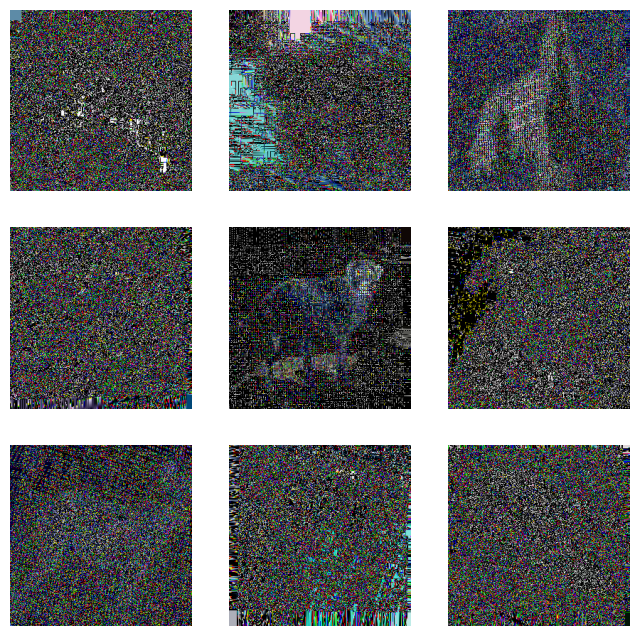

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of augmented images from the train_generator
batch = next(val_generator)  # You can specify the generator name here

# Visualize 9 random images from the batch
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(batch[0][i])  # Images are in the first part of the batch
    ax.axis('off')
plt.show()


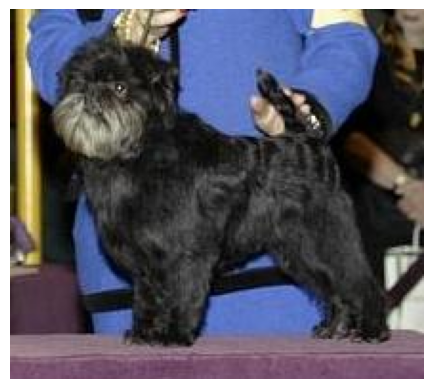

In [54]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Load a sample image (replace 'path_to_image.jpg' with an actual path)
img_path = 'resources/stanford-dogs-dataset/cropped-images/affenpinscher/n02110627_10147.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB (OpenCV loads images in BGR)

plt.imshow(img)
plt.axis("off")
plt.show()


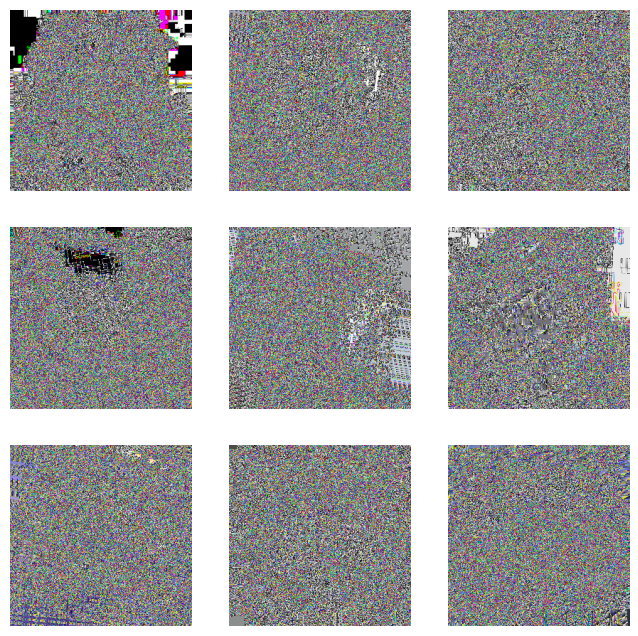

Min pixel value: -1.0
Max pixel value: 1.0


In [56]:
batch = next(train_generator)  # Get a batch

# Visualize a few processed images
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    img = batch[0][i]  # Get image
    img = ((img + 1) * 127.5).astype(np.uint8)  # Reverse MobileNet preprocessing (-1,1 -> 0,255)
    ax.imshow(img)
    ax.axis('off')

plt.show()

print("Min pixel value:", np.min(batch[0]))  # Should be around -1 (MobileNet format)
print("Max pixel value:", np.max(batch[0]))  # Should be around 1 (MobileNet format)


In [48]:
pip install opencv-python


   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.5 MB ? eta -:--:--
    --------------------------------------- 0.5/39.5 MB 349.5 kB/s eta 0:01:52
    --------------------------------------- 0.5/39.5 MB 349.5 kB/s eta 0:01:52
    --------------------------------------- 0.5/39.5 MB 349.5 kB/s eta 0

In [49]:
pip install opencv-python-headless


   ---------------------------------------- 0.0/39.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.4 MB ? eta -:--:--
    --------------------------------------- 0.5/39.4 MB 1.0 MB/s eta 0:00:38
    --------------------------------------- 0.8/39.4 MB 1.2 MB/s eta 0:00:34
   - -------------------------------------- 1.6/39.4 MB 1.6 MB/s eta 0:00:25
   - -------------------------------------- 1.8/39.4 MB 1.7 MB/s eta 0:00:23
   -- ------------------------------------- 2.4/39.4 MB 1.7 MB/s eta 0:00:22
   -- ------------------------------------- 2.6/39.4 MB 1.7 MB/s eta 0:00:22
   -- ------------------------------------- 2.9/39.4 MB 1.7 MB/s eta 0:00:22
   --- ------------------------------------ 3.1/39.4 MB 1.6 MB/s eta 0:00:23
   --- ------------------------------------ 3.7/39.4 MB 1.6 MB/s eta 0:00:23
   --- ------------------------------------ 3.9/39.4 MB 1.6 MB/s eta 0:00:23
   ---- ------------

In [55]:
print(np.min(batch[0]), np.max(batch[0]))  # Should be between 0-1 or 0-255


-1.0 1.0


In [20]:
# Test if images are correctly preprocessed
batch_images, batch_labels = next(train_generator)
print(f"Image batch shape: {batch_images.shape}")  
print(f"Label batch shape: {batch_labels.shape}")  
print(f"Pixel range: min={batch_images.min()}, max={batch_images.max()}")  # Should be ~[-1, 1]

Image batch shape: (32, 256, 256, 3)
Label batch shape: (32, 120)
Pixel range: min=-1.0, max=1.0


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import MobileNet

# Load MobileNet pre-trained with ImageNet weights
mn_base_model = MobileNet(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

# Freeze the base model
mn_base_model.trainable = False

# Define the model
mn_model = Sequential([
    mn_base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),  # Dense layer for learning
    Dense(NUM_CLASSES, activation='softmax')  # Output layer for classification (dog breeds)
])

# Compile the model
mn_model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Model summary to check architecture
mn_model.summary()


C:\Users\kbuma\AppData\Local\Temp\ipykernel_31852\964822495.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mn_base_model = MobileNet(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 8, 8, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 120)            │       123,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,401,464 (16.79 MB)

 Trainable params: 1,172,600 (4.47 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [27]:
history = mn_model.fit(
    train_generator,
    epochs=10,  # Start with 10 epochs
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),  # Total number of batches per epoch
    validation_steps=len(val_generator)   # Total number of batches per validation epoch
)


c:\Users\kbuma\anaconda3\envs\tflow\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 723s 1s/step - accuracy: 0.0152 - loss: 4.7870 - val_accuracy: 0.0238 - val_loss: 4.6074
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 796s 2s/step - accuracy: 0.0325 - loss: 4.5555 - val_accuracy: 0.0322 - val_loss: 4.5327
Epoch 3/10
135/516 ━━━━━━━━━━━━━━━━━━━━ 5:14 825ms/step - accuracy: 0.0364 - loss: 4.4699

KeyboardInterrupt: 

Ok so we are missing 10% of our data for some reason. I am dealing with that later. 
## Image Normalization

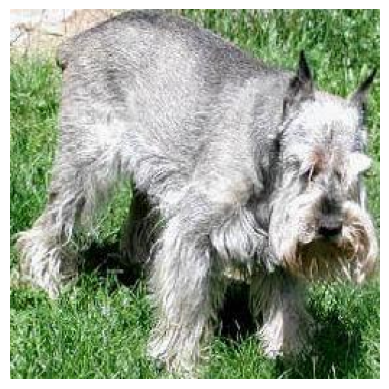

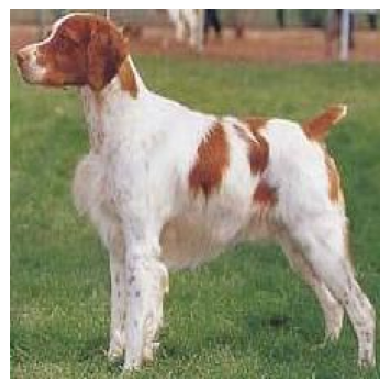

In [9]:
import matplotlib.pyplot as plt

# Displaying the first image in the batch
first_image = (batch_images[0] * 255).astype(np.uint8)  # Scale back to 0-255
plt.imshow(first_image)  # Display image with correct scaling
plt.axis('off')  # Hide axes
plt.show()

# Displaying the second image in the batch
second_image = (batch_images[1] * 255).astype(np.uint8)
plt.imshow(second_image)
plt.axis('off')
plt.show()


In [ ]:
# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
# from tensorflow.keras.optimizers import Adam

# # Load MobileNetV2 without the top layer
# mn_base_model = MobileNetV2(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')

# # Freeze the base model (so we don't train it initially)
# mn_base_model.trainable = False


C:\Users\kbuma\AppData\Local\Temp\ipykernel_91232\1909299449.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mn_base_model = MobileNetV2(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# # Create a new model on top of the base model
# x = mn_base_model.output
# x = GlobalAveragePooling2D()(x)  # Reduce dimensions
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.3)(x)  # Regularization
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.3)(x)
# output = Dense(NUM_CLASSES, activation='softmax')(x)  # Pass `x` into output layer

# # Create model
# mn_model = Model(inputs=mn_base_model.input, outputs=output)

# # Compile it
# mn_model.compile(optimizer=Adam(learning_rate=0.001),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # Print summary
# mn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 3,076,024 (11.73 MB)

 Trainable params: 818,040 (3.12 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = mn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Start small to test
    callbacks=[early_stopping]
)


c:\Users\kbuma\anaconda3\envs\tflow\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 605s 1s/step - accuracy: 0.0117 - loss: 4.8389 - val_accuracy: 0.0206 - val_loss: 4.7082
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 460s 891ms/step - accuracy: 0.0261 - loss: 4.6669 - val_accuracy: 0.0317 - val_loss: 4.5741
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 456s 883ms/step - accuracy: 0.0339 - loss: 4.5522 - val_accuracy: 0.0351 - val_loss: 4.5067
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 6361s 12s/step - accuracy: 0.0352 - loss: 4.5037 - val_accuracy: 0.0462 - val_loss: 4.4405
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 32372s 63s/step - accuracy: 0.0401 - loss: 4.4264 - val_accuracy: 0.0567 - val_loss: 4.3872
Epoch 6/10
150/516 ━━━━━━━━━━━━━━━━━━━━ 3:54:21 38s/step - accuracy: 0.0450 - loss: 4.4035

KeyboardInterrupt: 

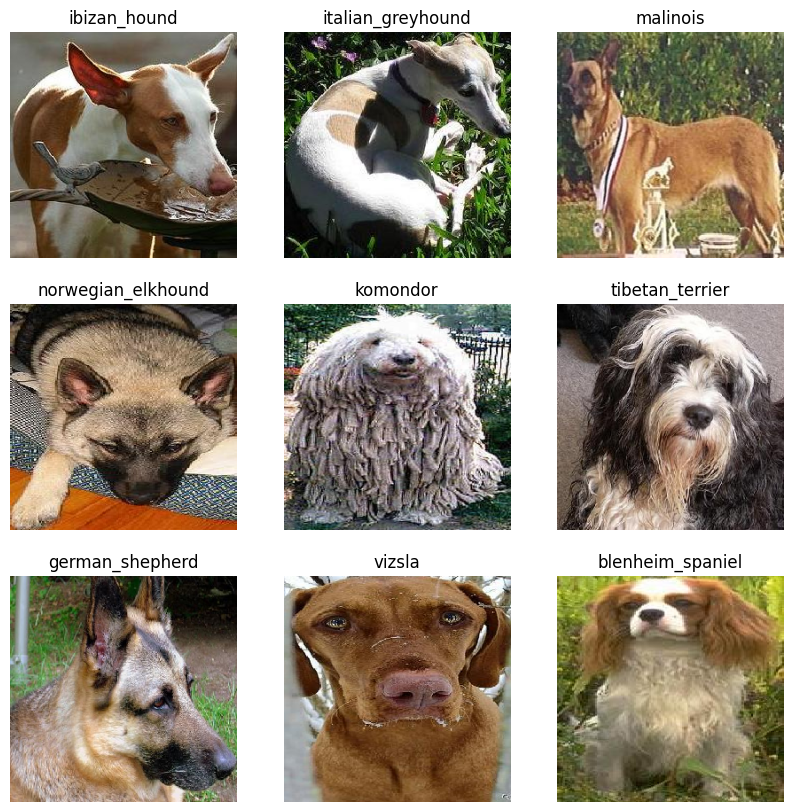

In [ ]:
batch_images, batch_labels = next(train_generator)

# Get class indices mapping (so we know which label corresponds to which breed)
class_indices = train_generator.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}  # Reverse mapping

# Plot some sample images with their supposed labels
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = (batch_images[i] * 255).astype(np.uint8)
    label_index = np.argmax(batch_labels[i])  # Get index of the predicted class
    label_name = inv_class_indices[label_index]  # Convert to breed name

    ax.imshow(img)
    ax.set_title(label_name)
    ax.axis("off")

plt.show()



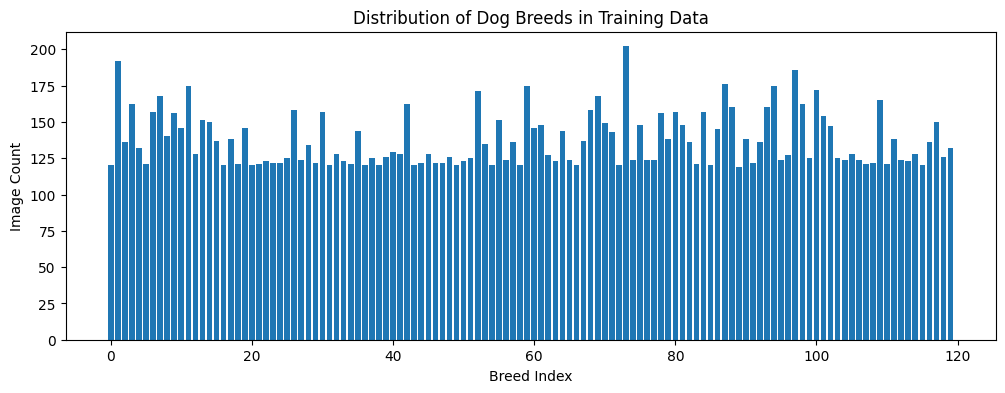

In [17]:
import collections

label_counts = collections.Counter(train_generator.classes)
plt.figure(figsize=(12, 4))
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel("Breed Index")
plt.ylabel("Image Count")
plt.title("Distribution of Dog Breeds in Training Data")
plt.show()


In [18]:
train_files = set(train_generator.filenames)
val_files = set(val_generator.filenames)

# Check if there’s any overlap
overlap = train_files.intersection(val_files)
print(f"⚠️ Found {len(overlap)} overlapping images between train and validation sets!")


⚠️ Found 0 overlapping images between train and validation sets!


Min pixel value: 0.0, Max pixel value: 255.0


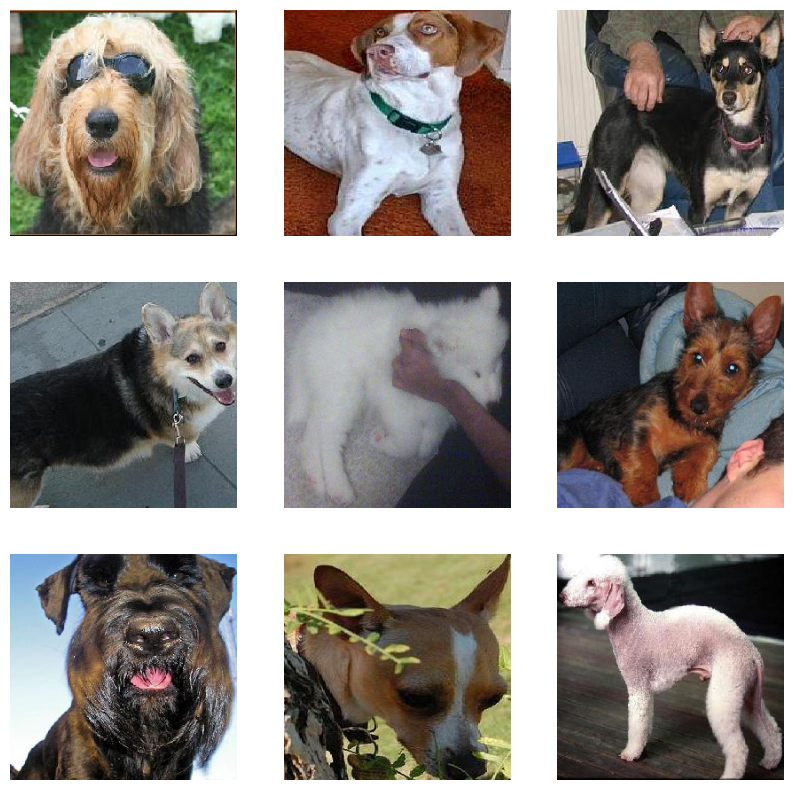

In [21]:
batch_images, batch_labels = next(train_generator)

# Check pixel range
print(f"Min pixel value: {batch_images.min()}, Max pixel value: {batch_images.max()}")

# Show a few images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = (batch_images[i] * 255).astype(np.uint8)  # Convert back to display
    ax.imshow(img)
    ax.axis("off")
plt.show()


In [28]:
sample_batch, _ = next(val_generator)  # Get some images from validation set
preds = mn_model.predict(sample_batch[:5])  # Predict first 5 images

print("Predictions:\n", preds)
print("Sum of each prediction row (should be ~1.0):\n", preds.sum(axis=1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Predictions:
 [[2.85644946e-03 8.62713438e-04 7.67455855e-03 7.54620938e-04
  1.51065839e-02 2.32257508e-02 8.71500233e-04 1.29641378e-02
  1.62966140e-02 1.69194508e-02 1.39952009e-03 2.66203415e-02
  3.36635858e-02 1.06430538e-02 2.53720814e-03 1.00546172e-02
  1.28027396e-02 7.13382324e-04 3.65783949e-03 2.59846002e-02
  1.36050780e-03 1.30975638e-02 2.24506762e-03 4.24944534e-04
  1.35819539e-02 2.58101150e-03 2.86566210e-04 2.23707817e-02
  4.10927320e-03 1.43312607e-02 3.12074757e-04 1.48498453e-03
  2.87595508e-03 5.00711100e-03 8.18413310e-03 4.44511941e-04
  5.91536518e-04 1.24091096e-03 3.31315249e-02 1.88684277e-02
  4.14918317e-03 1.30707361e-02 4.50903550e-02 7.59331556e-03
  8.89087282e-03 2.94308439e-02 5.07779513e-03 1.11264177e-02
  3.75970732e-03 1.36289664e-03 1.14910174e-02 2.40411498e-02
  1.67952606e-03 3.51037122e-02 4.36195405e-03 1.94003023e-02
  1.77507254e-03 5.39571862e-04 9.52214992e-04 4.10220789e-04
  1.57411043e-02 

In [25]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


NameError: name 'history' is not defined

In [26]:
sample_batch, _ = next(val_generator)  # Get a batch from validation set
preds = mn_model.predict(sample_batch[:5])  # Predict on first 5 images

# Print predictions
print("Predictions:\n", preds)
print("Sum of each prediction row (should be ~1.0):\n", preds.sum(axis=1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predictions:
 [[5.78782335e-03 6.17676124e-04 3.39013105e-03 5.99844439e-04
  1.25395432e-02 5.64542487e-02 8.97706079e-04 7.73542374e-03
  1.29458224e-02 1.55656850e-02 7.69603357e-04 4.80685756e-02
  3.04748546e-02 6.03967533e-03 1.84283336e-03 9.21883248e-03
  1.94518771e-02 7.13126967e-04 2.58719549e-03 2.84572430e-02
  2.15821923e-03 7.38166226e-03 2.06054654e-03 4.33805981e-04
  7.80982012e-03 2.71650986e-03 2.28106219e-04 1.93822533e-02
  4.64855228e-03 8.81081261e-03 2.09339603e-04 1.76768051e-03
  5.07372245e-03 9.88900010e-03 1.39600402e-02 3.64601146e-04
  2.84534093e-04 4.85033146e-04 2.31233295e-02 6.11832133e-03
  1.74988282e-03 1.70797743e-02 3.33954059e-02 5.22062695e-03
  1.69884674e-02 2.44026724e-02 2.01256550e-03 8.77881516e-03
  1.05899191e-02 1.07036752e-03 2.67350320e-02 2.85405908e-02
  1.91961811e-03 4.21032645e-02 1.21385129e-02 1.09024392e-02
  1.52918440e-03 3.44774191e-04 1.83207402e-03 2.23386945e-04
  9.05774813e-03 8.5

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Load ResNet50 pre-trained on ImageNet without the top layers (so we can add our own)
rn_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2]))

# Freeze the pre-trained layers
for layer in rn_base_model.layers:
    layer.trainable = False  # Freeze layers to prevent them from being trained

# Add your custom layers
x = rn_base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce dimensions
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout layer to avoid overfitting
x = Dense(NUM_CLASSES, activation='softmax')(x)  # Output layer for classification

# Create the model
rn_model = Model(inputs=rn_base_model.input, outputs=x)

# Compile the model
rn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summarize the model
rn_model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 25,808,888 (98.45 MB)

 Trainable params: 2,221,176 (8.47 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# # Unfreeze the top layers of the base model
# for layer in base_model.layers[-10:]:  # Unfreeze the top 10 layers (you can adjust this)
#     layer.trainable = True

# # Recompile the model (necessary after changing the trainable layers)
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Use a low learning rate for fine-tuning
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # Fine-tune the model
# history_finetune = model.fit(train_generator,
#                              validation_data=val_generator,
#                              epochs=10,  # Fine-tune for more epochs
#                              callbacks=[early_stopping])


Epoch 1/10
121/516 ━━━━━━━━━━━━━━━━━━━━ 12:15 2s/step - accuracy: 0.0126 - loss: 5.5103

KeyboardInterrupt: 

In [ ]:

# from tensorflow.keras.applications import VGG16

# VG_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2]))

# # Freeze the base layers
# VG_base_modelbase_model.trainable = False

# # Add custom layers on top
# VG_model = Sequential([
#     VG_base_model,
#     GlobalAveragePooling2D(),
#     Dense(512, activation='relu'),
#     Dropout(0.5),
#     Dense(NUM_CLASSES, activation='softmax')
# ])

# # Compile the model
# VG_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Train the model
# history = model.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=[early_stopping])



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 25,808,888 (98.45 MB)

 Trainable params: 2,221,176 (8.47 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [42]:
from tensorflow.keras.applications import InceptionV3

Inc_base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False  # Freeze layers to prevent them from being trained

# Add your custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce dimensions
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout layer to avoid overfitting
x = Dense(NUM_CLASSES, activation='softmax')(x)  # Output layer for classification

# Create the model
Inc_model = Model(inputs=base_model.input, outputs=x)

# Compile the model
Inc_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summarize the model
Inc_model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 25,808,888 (98.45 MB)

 Trainable params: 2,221,176 (8.47 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# def create_model(hp):
#     model = Sequential()

#     # First Conv Layer with tunable filters & activation
#     model.add(Conv2D(
#         filters=hp.Int('conv1_filters', min_value=16, max_value=128, step=32),
#         kernel_size=(3,3), activation=hp.Choice('activation', ['relu', 'tanh', 'sigmoid']),
#         input_shape=INPUT_SHAPE
#     ))
#     model.add(MaxPooling2D(2, 2))  # We can use MaxPooling2D here initially

#     # Allow kerastuner to decide number of Conv layers
#     for i in range(hp.Int('num_conv_layers', 1, 4)):
#         model.add(Conv2D(
#             filters=hp.Int(f'conv_filters_{i}', min_value=16, max_value=128, step=32),
#             kernel_size=(3,3), activation=hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])
#         ))
#         model.add(MaxPooling2D(2, 2))  # Add pooling here for additional reduction of spatial dimensions

#     model.add(GlobalAveragePooling2D())  # Apply GlobalAveragePooling2D later in the model

#     model.add(Flatten())

#     # Dense layers (fully connected) - tuning number of units and dropout rates
#     for i in range(hp.Int('num_dense_layers', 1, 3)):
#         model.add(Dense(
#             units=hp.Int(f'dense_units_{i}', min_value=64, max_value=512, step=64),
#             activation=hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])
#         ))
#         model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)))

#     # Output layer for multi-class classification
#     model.add(Dense(NUM_CLASSES, activation='softmax'))

#     # Compile the model
#     model.compile(
#         optimizer='adam',
#         loss='categorical_crossentropy',
#         metrics=['accuracy']
#     )

#     return model


In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# # Define tuner with faster settings
# tuner = RandomSearch(
#     create_model,
#     objective='val_accuracy',
#     max_trials=10,  # ⬇️ Less models to test (faster tuning)
#     executions_per_trial=1,  # ⬇️ Train each model ONCE instead of twice!
#     directory='kerastuner_results',
#     project_name='dog_breed_classifier'
)

c:\Users\kbuma\anaconda3\envs\tflow\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# # Ensure your data is in the right format
# print(f"Train Data: {train_generator}")
# print(f"Validation Data: {val_generator}")

# # To check how many batches per epoch:
# print(f"Train Batches per epoch: {train_generator.samples // train_generator.batch_size}")
# print(f"Validation Batches per epoch: {val_generator.samples // val_generator.batch_size}")


Train Data: <keras.src.legacy.preprocessing.image.DirectoryIterator object at 0x000001CFDA1D9750>
Validation Data: <keras.src.legacy.preprocessing.image.DirectoryIterator object at 0x000001CFD3B26800>
Train Batches per epoch: 515
Validation Batches per epoch: 127


In [ ]:
# # Run tuning
# tuner.search(train_generator, validation_data=val_generator, epochs=5)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
112               |112               |conv1_filters
tanh              |tanh              |activation
1                 |1                 |num_conv_layers
48                |48                |conv_filters_0
3                 |3                 |num_dense_layers
64                |64                |dense_units_0
0.4               |0.4               |dropout_0




c:\Users\kbuma\anaconda3\envs\tflow\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\kbuma\anaconda3\envs\tflow\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 984s 2s/step - accuracy: 0.0081 - loss: 4.8582 - val_accuracy: 0.0106 - val_loss: 4.7953
Epoch 2/5
206/516 ━━━━━━━━━━━━━━━━━━━━ 8:37 2s/step - accuracy: 0.0090 - loss: 4.8087

KeyboardInterrupt: 

In [ ]:
# # Get the best model
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# best_model = tuner.hypermodel.build(best_hps)

In [ ]:
# # Print model summary
# best_model.summary()  

In [ ]:
# # Train the best model
# history = best_model.fit(train_generator, validation_data=val_generator, epochs=20)

In [ ]:
model.save("dog_breed_classifier.h5")